# Trainer Notebook
#### Author: Yasa Baig

In this notebook, we define code for systematically tuning deep neural networks for causal embedding of one dimensional time series data. Models are defined in the `models` directory as well as a number of other useful utility functions. We begin by importing the necessary libraries and utilities.

In [1]:
# Install useful utilities
!pip install torchsummary

In [2]:
# Import core scientific python and deep learning libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange

# Configure GPU if available
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

display(device)

'cuda:0'

In [3]:
# Import all custom modules and libraries. The beginning script forces the Jupyter environement to reload all
# dependencies if they are updated. 
%load_ext autoreload
%autoreload 2

# Import datasets
from datasets.ECGDataset import ECGTrainingSet

from models.CausalAE import CausalAE
from utils.TimeSeriesUtils import plot_3D

### Training Our Model

We now instantiate and train our model for analysis. We will import our data, setup our training loop with hyperparameters, and run the model.

In [4]:
# Set hyperparameters
hp = {
    "in_channels" : 1, 
    "channels": 5, 
    "depth": 10,
    "reduced_size" : 3,
    "out_channels" : 3, 
    "kernel_size": 3,
    "window_length": 10,
    "lr": 0.01, 
    "epochs": 130,
    "batch_size": 50
}

First we will setup the model for computation.

In [5]:
# Set our model, force it double precision, and transfer it to the GPU.
model = CausalAE(hp)
model.double()
model.to(device);

Now we initialize our dataset and data loader.

In [6]:
# Generate our dataset
data = ECGTrainingSet(window_length = 10,truncate=30000)
display(data.H.shape)
data_loader = DataLoader(data, batch_size = hp["batch_size"])

torch.Size([30000, 1, 10])

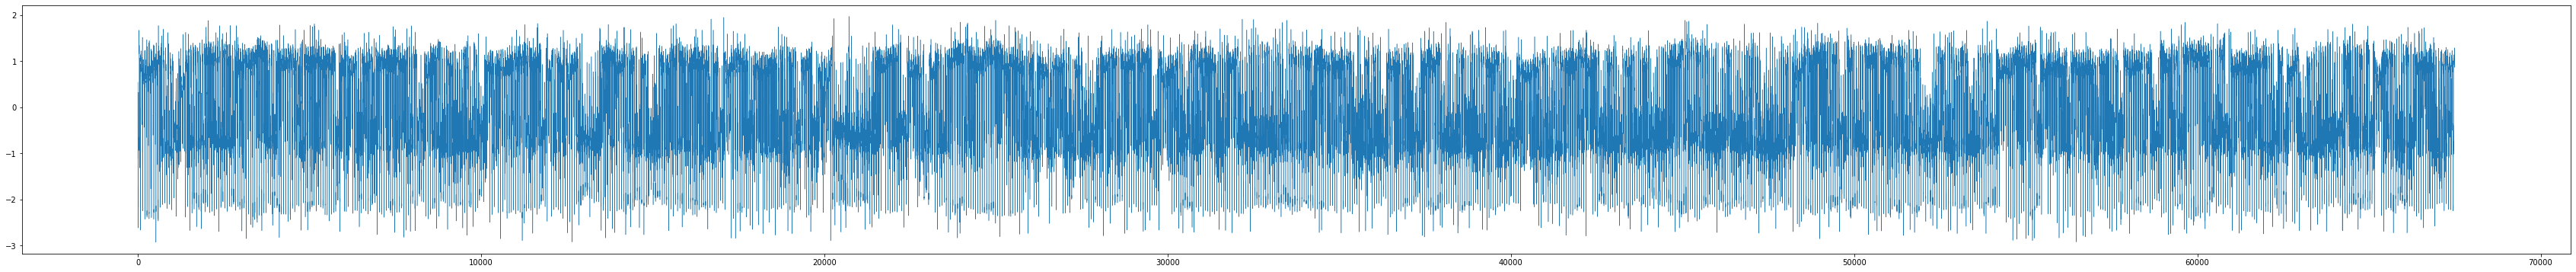

In [7]:
# Optionally plot the data
time_series = data.time_series
plt.figure(figsize = (60,6))
plt.plot(time_series,lw= 0.5)

Now we setup our optimizer and loss function. As we are performing a reconstruction problem we are using $\ell_2$ reconstruction loss. For our optimizer we are using simply Adam with default momentum hyperparameters, only tuning the learning rate `lr`.

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=hp["lr"])
criterion = torch.nn.MSELoss()

### Training

Lastly we will now train our model. We utilize `tqdm` for visualization of a progress bar, but otherwise our training loop is a standard PyTorch training loop.

In [ ]:
# Store the losses per epoch
running_losses = []

# Outerloop will iterate through epochs. tqdm function trange provides progressbar
for i in trange(hp["epochs"]):
    
    epoch_loss = 0 
    
    # Inner loop iterates through batches
    for batch in data_loader:
        
        # Transfer the batch to the GPU
        batch = batch.to(device)
        
        # Uncomment to verify batch dimension
        # print("BATCH SHAPE: " + str(batch.shape))
        
        # Zero gradient
        optimizer.zero_grad()
        
        # Perform forward pass
        pred = model(batch)
        
        # Uncomment to verify model prediction shape
        # print("PREDI SHAPE: " + str(pred.shape))
        
        # Compute reconstruction loss
        batch_loss = criterion(pred,batch)
        
        # Compute gradient
        batch_loss.backward()
        
        # Take step
        optimizer.step()
        
        # Append to running epoch loss
        epoch_loss += batch_loss.item()
        
    # Keep running track of losses
    if i % 5 == 0:
        print(f"Epoch [{i}]: " + str(epoch_loss))
    
    running_losses.append(epoch_loss)

Epoch [0]: 182.06827100226621
Epoch [5]: 84.23479321418246
Epoch [10]: 83.95078925465938
Epoch [15]: 75.42402571234572
Epoch [20]: 73.72123522761774
Epoch [25]: 71.5640029399603
Epoch [30]: 69.13707384973533
Epoch [35]: 69.13234752598277
Epoch [40]: 67.09833425368703
Epoch [45]: 66.98875232135498
Epoch [50]: 67.06944339245423
Epoch [55]: 66.73069491126607
Epoch [60]: 66.35212456862263
Epoch [65]: 66.60687796316358
Epoch [70]: 65.07850703027208
Epoch [75]: 65.55298279708094
Epoch [80]: 67.31593137996852
Epoch [85]: 65.41584005376694
Epoch [90]: 64.80702137572507
Epoch [95]: 65.09262861214879
Epoch [100]: 64.8087122473056
Epoch [105]: 65.29055852888322
Epoch [110]: 64.95233625376365
Epoch [115]: 64.39586710654143
Epoch [120]: 64.03329606866114


### Evaluating the Predictions

Following training, we now visualize our generating embeddings to see how good they are.

In [ ]:
# Pull of the data from our model
H = data.H
H = H.to(device)

# Generate embeddings using only the encoder portion of our model
embeddings = model.encoder(H)

We now will unpack our embeddings from the GPU, transfer to numpy, and visualize.

In [ ]:
# Clean the embeddings into a single matrix and convert to CPU numpy
embeddings = embeddings.squeeze().cpu().detach().numpy()

xl = embeddings[:,0]
yl = embeddings[:,1]
zl = embeddings[:,2]

Plot this on a $\mathbb{R}^3$ grid.

In [ ]:
plot_3D(xl,yl,zl, title = "Embedded ECG", lw = 0.05)

In [ ]:
# Save the embeddings
import pandas as pd

df = pd.DataFrame(embeddings)
df.to_csv("./saved_embeddings/ecg.csv")